In [368]:
import networkx as nx
import pandas as pd
import numpy as np
import sqlite3
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from itertools import combinations
import igraph as ig
import copy
%config InlineBackend.figure_formats = ['svg']

### Load Data


In [369]:
con = sqlite3.connect("emps.db")

module = pd.read_sql_query("SELECT * FROM module", con)
module_discipline = pd.read_sql_query("SELECT * FROM module_discipline", con)
programme = pd.read_sql_query("SELECT * FROM programme", con)
requisite = pd.read_sql_query("SELECT * FROM requisite", con)
staff = pd.read_sql_query("SELECT * FROM staff", con)
stage_module = pd.read_sql_query("SELECT * FROM stage_module", con)
MSC_titles = pd.read_csv("MSC_titles_2020.csv")

In [370]:
edge_sql = """
WITH filtered_modules AS (
	SELECT DISTINCT
		moduleCode
	FROM
		stage_module
	WHERE
		stage_module.moduleCode IS NOT NULL
		AND moduleTitle NOT LIKE '%elective%'
		AND moduleTitle NOT LIKE '%free choice%'
		AND stage_module.program_id IN(
			SELECT
				id FROM programme
			WHERE
				"year" BETWEEN 2021 AND 2024
				AND title LIKE '%mathematics%'
				AND programme. "type" = "Undergraduate")
)
SELECT
	*
FROM
	"requisite"
WHERE
	requisite. "module" IN filtered_modules
	AND requisite.requires IN filtered_modules;
"""
edge_df = pd.read_sql_query(edge_sql, con)
node_sql = """
SELECT DISTINCT
	MIN(sm.stage) AS stage,
	sm.moduleCode,
	sm.moduleTitle,
	sm.moduleCredits,
	m.credit,
	MIN(sm.isCompulsory) AS IsCompulsory,
	MAX(sm.isNonCondonable) AS IsNonCondonable,
	m.studentsCount,
	m.year
FROM
	stage_module AS sm
	LEFT JOIN "module" AS m ON sm.moduleCode = m.moduleCode
WHERE
	sm.moduleCode IS NOT NULL
	AND sm.moduleTitle NOT LIKE '%elective%'
	AND sm.moduleTitle NOT LIKE '%free choice%'
	AND sm.moduleCode NOT IN('xxxxxxx', 'BE*M**', 'BE*M***', 'BEE3*', 'BEE3***', 'BEE3****', 'BEE3XXX', 'BEM2***', 'BIOMXXX', 'MTH****', 'MTH2XXX/3XXX', 'MTH3***', 'PHYMXXX', 'GEOMXXX')
	AND sm.program_id IN(
		SELECT
			id FROM programme
		WHERE
			"year" BETWEEN 2021 AND 2024
			AND title LIKE '%mathematics%'
			AND programme. "type" = "Undergraduate")
GROUP BY
	sm.moduleCode;
"""
node_df = pd.read_sql_query(node_sql, con)

all_modules_nx = nx.DiGraph()

for index, row in node_df.iterrows():
    node_id = row["moduleCode"]
    attributes = {k: v for k, v in row.items() if k != "moduleCode"}
    all_modules_nx.add_node(node_id, **attributes)

for index, row in edge_df.iterrows():
    source = row["module"]
    target = row["requires"]
    attributes = {k: v for k, v in row.items() if k != "module" and k != "requires"}
    all_modules_nx.add_edge(source, target, **attributes)
    all_modules_nx.edges[source, target]["label"] = "requires"

### Subject Choice Data


In [371]:
J_y1 = ["ECM1400", "ECM1410", "ECM1413", "ECM1414", "MTH1001", "MTH1002"]
J_y2 = [
    "ECM2414",
    "ECM2418",
    "ECM2419",
    "ECM2423",
    "ECM2433",
    "ECM2434",
    "MTH2008",
    "MTH2011",
]
J_y3 = ["ECM3401", "ECM3408", "ECM3420", "ECM3423", "MTH3019", "MTH3022"]

def create_student_graph(student_modules: list[str], student_name: str) -> nx.DiGraph:
    S: nx.DiGraph = all_modules_nx.subgraph(student_modules).copy()
    MSC_data = pd.read_csv(f"msc_data/{student_name}.csv")

    # Assert that all modules listed in CSV are taken by student
    msc_modules = list(MSC_data.iloc[:, 0].unique())
    assert all(map(lambda x: x in student_modules, msc_modules))

    # Assert that all MSC listed in CSV are legitimate
    chosen_msc_codes = list(MSC_data.iloc[:, 1].unique())
    assert all(map(lambda x: x in list(MSC_titles.iloc[:,0].unique()), chosen_msc_codes))

    list_of_tuples = [tuple(x) for x in MSC_data.to_records(index=False)]
    S.add_edges_from(list_of_tuples, label="uses")

    for v, data in S.nodes(data=True):
        if "moduleTitle" in data:
            S.nodes[v]["color"] = "black"
        else:
            S.nodes[v]["color"] = "blue"

    for e in S.edges(data=True):
        data = e[2]
        if data["label"] == "requires":
            S.edges[e[0], e[1]]["color"] = "black"
        elif data["label"] == "uses":
            S.edges[e[0], e[1]]["color"] = "blue"

    return S
    

create_student_graph(J_y1 + J_y2 + J_y3, "J")

In [372]:
J_y1 = ["ECM1400", "ECM1410", "ECM1413", "ECM1414", "MTH1001", "MTH1002"]
J_y2 = [
    "ECM2414",
    "ECM2418",
    "ECM2419",
    "ECM2423",
    "ECM2433",
    "ECM2434",
    "MTH2008",
    "MTH2011",
]
J_y3 = ["ECM3401", "ECM3408", "ECM3420", "ECM3423", "MTH3019", "MTH3022"]
J = create_student_graph(J_y1 + J_y2 + J_y3, "J")

In [373]:
L_y1 = ["MTH1001", "MTH1002", "MTH1003", "MTH1004"]
L_y2 = [
    "MTH2003",
    "MTH2004",
    "MTH2008",
    "MTH2009",
    "MTH2010",
    "MTH2011",
]  # NOTE: and sociology modules
L_y3 = [
    "MTH3004",
    "MTH3022",
    "MTH3019",
    "MTH3042",
    "MTH3035",
]  # NOTE: and sociology modules

L = create_student_graph(L_y1 + L_y2 + L_y3, "L")

In [374]:
M_y1 = ["ECM1400", "ECM1410", "ECM1413", "ECM1414", "MTH1001", "MTH1002"]
M_y2 = [
    "ECM2414",
    "ECM2418",
    "MTH2010",
    "ECM2427",
    "ECM2433",
    "ECM2434",
    "MTH2008",
    "MTH2011",
]
M_y3 = ["ECM3420", "ECM3428", "MTH3004", "MTH3019", "ECM3408", "ECM3401"]

M = create_student_graph(M_y1 + M_y2 + M_y3, "M")

In [375]:
BJ_y1 = ["MTH1001", "MTH1002", "MTH1003", "MTH1004"]
BJ_y2 = ["MTH2003", "MTH2004", "MTH2005", "MTH2006", "MTH2008", "MTH2009"]
BJ_y3 = [
    "BEM2031",
    "BEM2036",
    "MTH3024",
    "MTH3028",
    "MTH3030",
    "MTH3035",
    "MTH3042",
    "MTH3045",
]

BJ = create_student_graph(BJ_y1 + BJ_y2 + BJ_y3, "B")

In [376]:
JLT_y1 = ["MTH1001", "MTH1002", "MTH1003", "MTH1004"]
JLT_y2 = ["MTH2003", "MTH2006", "MTH2008", "MTH2010", "MTH2011", "BEE1038", "BEM2036"]
JLT_y3 = ["BEM2031", "MTH3019", "MTH3024", "MTH3028", "MTH3045"]

JT = create_student_graph(JLT_y1 + JLT_y2 + JLT_y3, "JT")

In [377]:
CC_y1 = ["MTH1001", "MTH1002", "MTH1003", "MTH1004"]
CC_y2 = ["MTH2003", "MTH2006", "MTH2008", "MTH2010", "MTH2011", "BEE1038", "MTH2009"]
CC_y3 = [
    "MTH3028",
    "BEM2031",
    "MTH3004",
    "MTH3024",
    "MTH3038",
    "MTH3026",
    "MTH3022",
    "MTHM036",
]

CC = create_student_graph(CC_y1 + CC_y2 + CC_y3, "C")

In [378]:
EP_y1 = ["MTH1001", "MTH1002", "MTH1003", "MTH1004"]
EP_y2 = ["MTH2003", "MTH2004", "MTH2005", "MTH2008", "MTH2009", "MTH2010"]
EP_y3 = [
    "MTH3019",
    "MTH3022",
    "MTH3035",
    "MTH3042",
    "MTH3007",
    "MTH3011",
]  # + German Beginners

EP = create_student_graph(EP_y1 + EP_y2 + EP_y3, "E")

In [379]:
ZL_y1 = ["MTH1001", "MTH1002", "MTH1003", "MTH1004"]
ZL_y2 = ["MTH2003", "MTH2004", "MTH2005", "MTH2006", "MTH2008", "MTH2009"]
ZL_y3 = ["MTH3035", "MTH3006", "MTH3007", "MTH3042", "MTH3022", "BEM3060", "BEM3052"]

ZL = create_student_graph(ZL_y1 + ZL_y2 + ZL_y3, "Z")

In [380]:
IW_y1 = ["MTH1001", "MTH1002", "MTH1003", "MTH1004"]
IW_y2 = ["MTH2003", "MTH2004", "MTH2005", "MTH2008", "MTH2009"]
IW_y3 = [
    "MTH3035",
    "MTH3006",
    "MTH3007",
    "MTH3042",
    "MTH3022",
    "MTH3011",
    "BEM3060",
    "BEM3052",
]

IW = create_student_graph(IW_y1 + IW_y2 + IW_y3, "I")

In [381]:
K_y1 = ["MTH1001", "MTH1002", "MTH1003", "MTH1004"]
K_y2 = ["MTH2003", "MTH2006", "MTH2008", "MTH2009", "MTH2010", "MTH2011", "BEM1006"]
K_y3 = [
    "MTH3042",
    "MTH3022",
    "MTH3024",
    "MTH3035",
    "BEM2007",
    "BEM3060",
    "MTH3040",
    "MTH3028",
]

K = create_student_graph(K_y1 + K_y2 + K_y3, "K")

### People Intersection & Combination


In [382]:
people = [J, M, L, EP, CC, K, BJ, ZL, IW, JT]
people_names = ["J","M","L","E","C","K","B","Z","I","JT"]

all_nx = nx.compose_all(people).copy()

for node in all_nx.nodes:
    score = 0
    for P in people:
        if node in P:
            score += 1
    all_nx.nodes[node]["count"] = score

## LLM Prompt Generator

In [383]:
all_module_codes = list(all_nx.nodes)
pre_prompt = "This is a universities module description"
prompt = "Using the MSC subject classifications, classify this module. Only answer if you know the answer with certainty. Justify your answers. List the classification or classifications inside <classification> XML tags."

all_module_codes = sorted(all_module_codes)

for module_code in all_module_codes:
    m = module[module["moduleCode"] == module_code]
    if m.empty:
        continue
    m = m.iloc[0]
    t = ' '.join(f"<title>{m['title']}</title>".split())
    c = ' '.join(f"<code>{module_code}</code>".split())
    d = ' '.join(f"<description>{m['descriptionHTML']}</description>".split())
    a = ' '.join(f"<aims>{m['aimsHTML']}</aims>".split())
    l = ' '.join(f"<outcomes>{m['learningOutcomesHTML']}</outcomes>".split())
    s = ' '.join(f"<syllabus>{m['syllabusHTML']}</syllabus>".split())
    k = ' '.join(f"<keywords>{m['keywords']}</keywords>".split())
    p = f"{pre_prompt}\n\n{t}\n{c}\n{d}\n{a}\n{l}\n{s}\n{k}\n\n{prompt}"
    
    print("========================")
    print(p)
    print("========================")

This is a universities module description

<title>Programming</title>
<code>ECM1400</code>
<description>We use computers in almost all aspects of our daily lives and throughout science, so it is easy to take them for granted. However, in order that we can use computers to solve new problems and create new things, we have to be able to program them. This module introduces you to programming and problem solving with a computer. You will learn how to formulate an algorithm to solve a problem, and you will acquire the skills to write, test and debug programs.</description>
<aims>This module is an introductory course in computer programming and will introduce you to the fundamental concepts of computer algorithms and programming, with a strong emphasis on practical implementation. You will also learn how to apply analytical and problem-solving skills to the design and implementation of small applications.</aims>
<outcomes>On successful completion of this module, you should be able to: Modul

### Comparison Functions


In [384]:
def overlap_coefficient(X, Y):
    intx = nx.intersection(X, Y)
    return len(intx.edges) / min(len(X.edges), len(Y.edges))

In [385]:
def jaccard_index(X, Y):
    intersection = nx.intersection(X, Y)
    union = nx.compose(X, Y)
    return len(intersection) / len(union)

In [386]:
def node_symetric_difference(X, Y):
    intx = nx.intersection(X, Y)
    union = nx.compose(X, Y)
    return len(union.edges - intx.edges)

In [387]:
def compare_laplacian(X, Y):
    X_lap = nx.laplacian_spectrum(X.to_undirected())
    Y_lap = nx.laplacian_spectrum(Y.to_undirected())

    penalty = abs(len(X_lap) - len(Y_lap))
    longest = max(len(X_lap), len(Y_lap))

    X_lap = np.pad(X_lap, (0, longest - len(X_lap)))
    Y_lap = np.pad(Y_lap, (0, longest - len(Y_lap)))

    manhattan_distance = np.sum(np.abs(X_lap - Y_lap))

    return manhattan_distance + penalty

In [388]:
def compare_adjacency(X, Y):
    X_adj = nx.adjacency_spectrum(X.to_undirected())
    Y_adj = nx.adjacency_spectrum(Y.to_undirected())

    penalty = abs(len(X_adj) - len(Y_adj))
    longest = max(len(X_adj), len(Y_adj))

    X_adj = np.pad(X_adj, (0, longest - len(X_adj)))
    Y_adj = np.pad(Y_adj, (0, longest - len(Y_adj)))

    manhattan_distance = np.sum(np.abs(X_adj - Y_adj))

    return manhattan_distance + penalty

### Graph Comparisons


In [389]:
def compare_graph_similarity(graphs, functions):
    pairs = list(combinations(range(len(graphs)), 2))
    outputs = {}
    for func in functions:
        results = np.zeros((len(graphs), len(graphs)))
        for X, Y in pairs:
            results[X, Y] = results[Y, X] = func(graphs[X], graphs[Y])
        outputs[func.__name__] = results
    return outputs

In [390]:
comparison_functions = [
    overlap_coefficient,
    jaccard_index,
    node_symetric_difference,
    compare_laplacian,
    compare_adjacency,
]
similarities = compare_graph_similarity(people, comparison_functions)

for n, m in similarities.items():
    with np.printoptions(precision=3, suppress=True):
        print(f"{n} matrix:")
        # print(m)
        print(
            np.array2string(
                m,
                separator=" & ",
                max_line_width=np.inf,
                formatter={"int": lambda x: f"{x:d}"},
            )
        )

selected_measure = "node_symetric_difference"
distance_matrix = similarities[selected_measure]

name_mapping = {index: value for index, value in enumerate(people_names)}

distance_nx = nx.from_numpy_array(distance_matrix)
nx.relabel_nodes(distance_nx, name_mapping, False)

distances_nx = distance_nx.copy()
for u, v, data in distances_nx.edges(data=True):
    if "weight" in data:
        data["weight"] = round(data["weight"], 2)

overlap_coefficient matrix:
[[0.    & 0.753 & 0.328 & 0.266 & 0.281 & 0.302 & 0.172 & 0.215 & 0.231 & 0.367] &
 [0.753 & 0.    & 0.388 & 0.281 & 0.344 & 0.333 & 0.203 & 0.215 & 0.2   & 0.469] &
 [0.328 & 0.388 & 0.    & 0.672 & 0.641 & 0.698 & 0.594 & 0.662 & 0.615 & 0.653] &
 [0.266 & 0.281 & 0.672 & 0.    & 0.453 & 0.556 & 0.625 & 0.734 & 0.812 & 0.551] &
 [0.281 & 0.344 & 0.641 & 0.453 & 0.    & 0.683 & 0.516 & 0.438 & 0.391 & 0.755] &
 [0.302 & 0.333 & 0.698 & 0.556 & 0.683 & 0.    & 0.651 & 0.603 & 0.556 & 0.735] &
 [0.172 & 0.203 & 0.594 & 0.625 & 0.516 & 0.651 & 0.    & 0.703 & 0.656 & 0.653] &
 [0.215 & 0.215 & 0.662 & 0.734 & 0.438 & 0.603 & 0.703 & 0.    & 0.815 & 0.551] &
 [0.231 & 0.2   & 0.615 & 0.812 & 0.391 & 0.556 & 0.656 & 0.815 & 0.    & 0.408] &
 [0.367 & 0.469 & 0.653 & 0.551 & 0.755 & 0.735 & 0.653 & 0.551 & 0.408 & 0.   ]]
jaccard_index matrix:
[[0.    & 0.685 & 0.229 & 0.212 & 0.2   & 0.198 & 0.138 & 0.172 & 0.174 & 0.247] &
 [0.685 & 0.    & 0.25  & 0.191 & 0.20

### Clustering / Community Detection


In [408]:
clustering = DBSCAN(eps=44, min_samples=2, metric="precomputed")
clustering.fit(distance_matrix)
clustering.labels_

array([0, 0, 1, 2, 1, 1, 2, 2, 2, 1])

In [392]:
km = KMeans(n_clusters=4).fit(distance_matrix)
km.labels_

array([1, 1, 0, 2, 0, 0, 2, 2, 2, 0], dtype=int32)

In [410]:
comp = nx.community.girvan_newman(distances_nx)
tuple(sorted(c) for c in next(comp))

(['J'], ['B', 'C', 'E', 'I', 'JT', 'K', 'L', 'M', 'Z'])

In [412]:
nx.community.louvain_communities(distances_nx, resolution=1.1)

[{'K', 'M', 'Z'}, {'B', 'C', 'E', 'J', 'L'}, {'I', 'JT'}]

# Visualisations


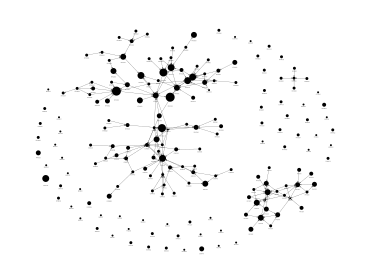

In [395]:
all_modules_ig = ig.Graph.from_networkx(all_modules_nx)

sizes = [v["studentsCount"] for v in all_modules_ig.vs]
normalized_sizes = np.interp(sizes, (np.nanmin(sizes), np.nanmax(sizes)), (3, 9))

for i, v in enumerate(all_modules_ig.vs):
    size = normalized_sizes[i]
    size = 2 if np.isnan(size) else size
    v["size"] = size

layout = all_modules_ig.layout_fruchterman_reingold(niter=1000)

fig, ax = plt.subplots()
pl = ig.plot(
    all_modules_ig,
    target=ax,
    layout=layout,
    margin=0,
    vertex_label=[v["_nx_name"] for v in all_modules_ig.vs],
    vertex_label_dist=2,
    vertex_label_size=0.5,
    vertex_color="black",
    edge_width=0.2,
    vertex_frame_width=0,
    bbox=(1200, 1200),
    edge_arrow_size=1,
    edge_arrow_width=1,
)
fig.savefig("images/all.svg", transparent=True)
plt.show()

In [396]:
def small_vis(
    G,
    target,
    vertex_color="black",
    layout="auto",
    margin=0,
    vertex_size=10,
    vertex_label=None,
    vertex_label_dist=2,
    vertex_label_size=7,
    edge_width=1,
    vertex_frame_width=0,
    edge_arrow_size=3,
    edge_arrow_width=3,
    **kwargs
):
    vertex_label = (
        [v["_nx_name"] for v in G.vs]
        if vertex_label is None
        else (
            [v[vertex_label] for v in G.vs]
            if isinstance(vertex_label, str)
            else vertex_label
        )
    )
    return ig.plot(
        G,
        target=target,
        vertex_color=vertex_color,
        layout=layout,
        margin=margin,
        vertex_size=vertex_size,
        vertex_label=vertex_label,
        vertex_label_dist=vertex_label_dist,
        vertex_label_size=vertex_label_size,
        edge_width=edge_width,
        vertex_frame_width=vertex_frame_width,
        edge_arrow_size=edge_arrow_size,
        edge_arrow_width=edge_arrow_width,
        **kwargs
    )

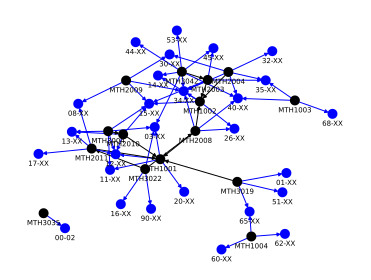

In [397]:
L_ig = ig.Graph.from_networkx(L)

fig, ax = plt.subplots()
pl = pl = small_vis(L_ig, ax, vertex_color=None, edge_color=None)
fig.savefig("images/L.svg", transparent=True)
plt.show()

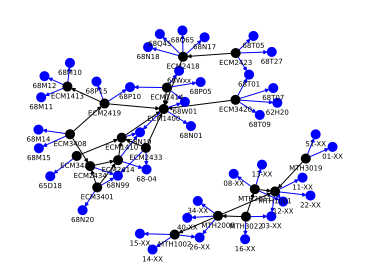

In [398]:
J_ig = ig.Graph.from_networkx(J)

fig, ax = plt.subplots()
pl = pl = small_vis(J_ig, ax, vertex_color=None, edge_color=None)
fig.savefig("images/J.svg", transparent=True)
plt.show()

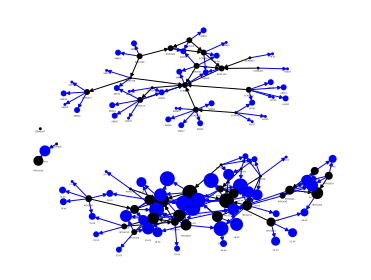

In [399]:
filter_list = [n[0] for n in all_nx.nodes(data=True) if 'moduleTitle' in n[1]]
filtered_all_nx = all_nx.subgraph(filter_list)

# all_ig = ig.Graph.from_networkx(filtered_all_nx)
all_ig = ig.Graph.from_networkx(all_nx)

sizes = [v["count"] for v in all_ig.vs]
sizes = np.interp(sizes, (np.min(sizes), np.max(sizes)), (5, 15))
sizes = [s if s != 5 else 3 for s in sizes]
fig, ax = plt.subplots()
pl = pl = small_vis(all_ig, ax, layout="auto", vertex_size=sizes,vertex_color=None, vertex_label_size=2)
fig.savefig("images/10combined.svg", transparent=True)
plt.show()

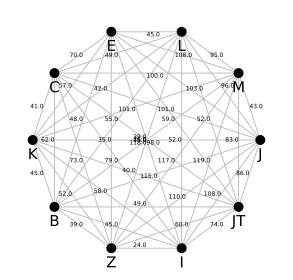

In [400]:
distances_ig = ig.Graph.from_networkx(distances_nx)

fig, ax = plt.subplots()
ax.set_aspect("equal")
pl = pl = small_vis(
    distances_ig,
    ax,
    layout="circle",
    edge_label=[x["weight"] for x in distances_ig.es],
    vertex_label_size=15,
    vertex_label_dist=3,
    edge_label_size=6,
    edge_color="gray",
    bbox=(1200, 1200),
)
fig.savefig(f"images/K_{selected_measure}.svg", transparent=True)
plt.show()